In [2]:
import rdkit
import json
import torch
import numpy as np
from tqdm import tqdm
# import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
import pickle
import os

# from evaluation.conformer import parse_embedded_smiles, get_conformer_statistics, calculate_rmsd, calculate_rmsd_matrix, get_embedded_smiles


In [10]:
DATA = "/auto/home/davit/3DMolGen/data/geomdrugs/censo"
MAX_MOLS = 1000

lines = []

summary = json.load(open(f"{DATA}/summary.json"))
i = 0
for smi, v in summary.items():
    if i > MAX_MOLS:
        break
    data = pickle.load(open(f"{DATA}/{v['pickle_path']}", "rb"))
    mol = data['conformers'][0]['rd_mol']
    lines.append(get_embedded_smiles(mol))
    

DATA = "/auto/home/davit/3DMolGen/data/geomdrugs/censo/embedded_smiles.jsonl"
with open(DATA, "w") as f:
    for line in lines:
        f.write(json.dumps(line) + "\n")

In [3]:
# DATA = "/auto/home/menuab/code/3DMolGen/data/pcqm_old_format/valid/pcqm_embedded_valid.jsonl"
DATA = "/auto/home/menuab/code/3DMolGen/data/pcqm/valid/pcqm_embedded_valid.jsonl"
BINS = 30


In [4]:
tokenizer  = AutoTokenizer.from_pretrained("/auto/home/menuab/code/YNNtitan/torchtitan/tokenizers/Llama-3.2-chem-1B-v1")
# model = AutoModelForCausalLM.from_pretrained("/nfs/h100/raid/chem/checkpoints/hf/yerevann/Llama-3.2-1B_conformers/77f5caabeda14ea6acbae86a/step-36000")
model = AutoModelForCausalLM.from_pretrained("/nfs/h100/raid/chem/checkpoints/hf/yerevann/Llama-3.2-1B_conformers/995b27050bbe4f518a1e33e8/step-26000")

In [5]:
smiles = []
embedded_smiles = []
prop_values = []

with open(DATA, "r") as f:
    for line in f:
        data = json.loads(line)
        canonical_smiles = data["canonical_smiles"]
        smiles.append(canonical_smiles)
        embedded_smiles.append(data['conformers']["embedded_smiles"])
        prop_values.append(data.get('pcqm4v2_label', 0))

In [6]:
# Parse the 'canonical_smiles' field from the JSONL file
output_2d_sdf = "./valid_2d.sdf"
sdf_writer = rdkit.Chem.SDWriter(output_2d_sdf)
for i, smi in enumerate(smiles):
    mol = rdkit.Chem.MolFromSmiles(smi)
    if mol is None:
        print(f"Failed to parse {smi}")
        continue

    mol.SetProp("_Name", smi)
    mol.SetProp("smi", smi)
    mol.SetIntProp("index", i)
    sdf_writer.write(mol)
sdf_writer.close()


In [7]:
gt_mols = [parse_embedded_smiles(smi) for smi in embedded_smiles]

In [9]:
# skip warnings
import warnings
warnings.filterwarnings("ignore")

model.to("cuda:1")

smi = []
conf_mols = []
smi_same = []
posebusters = []
predicted_props = []
rmsds = []

batch_size = 50
num_mols = len(gt_mols)
tokenizer.pad_token = tokenizer.eos_token

for batch_start in tqdm(range(0, num_mols, batch_size)):
    batch_gmols = gt_mols[batch_start:batch_start + batch_size]
    
    # Prepare prompts for the batch
    prompts = [
        f"[SMILES]{rdkit.Chem.MolToSmiles(gt_mol, canonical=True, isomericSmiles=False)}[/SMILES]"
        for gt_mol in batch_gmols
    ]
    
    # Tokenize the batch
    inputs = tokenizer(
        prompts, 
        return_tensors="pt", 
        add_special_tokens=True, 
        padding=True,
        padding_side="left"
    ).to(model.device).input_ids
    
    # Generate outputs for the batch
    outputs = model.generate(inputs, max_length=1000)
    decoded_outputs = tokenizer.batch_decode(outputs)
    
    for output, gt_mol in zip(decoded_outputs, batch_gmols):
        try:
            prop = float(
                output.split("PROPERTY")[1].split("</PROPERTY>")[0].strip()[1:-2]
            )
            predicted_props.append(prop)
        except (IndexError, ValueError):
            predicted_props.append(None)
        
        try:
            conf_smi = output.split("CONFORMER")[1].split("</CONFORMER>")[0].strip()[1:-2]
            conf_mol = parse_embedded_smiles(conf_smi)
            conf_mols.append(conf_mol)

            rmsd = calculate_rmsd(conf_mol, gt_mol)
            smi.append(conf_smi)
            rmsds.append(rmsd)
        except (IndexError, ValueError):
            rmsd = None
            rmsds.append(rmsd)
            smi.append(None)
        
        try:
            same_smi = rdkit.Chem.MolToSmiles(conf_mol, canonical=True, isomericSmiles=False) \
                        == rdkit.Chem.MolToSmiles(gt_mol, canonical=True, isomericSmiles=False)
            smi_same.append(same_smi)
        except:
            smi_same.append(False)
        
        try:
            stats = get_conformer_statistics(conf_mol)['results']
            posebusters.append(stats)
        except:
            posebusters.append(None)

  0%|          | 0/20 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
  5%|▌         | 1/20 [00:17<05:33, 17.55s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
 10%|█         | 2/20 [00:34<05:14, 17.47s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `at

# Results

In [32]:
print("Percentage of coinciding canonical SMILES:", sum(smi_same) / len(smi_same))
print("\n")

print("MSE of predicted property values:", np.mean((np.array(predicted_props) - np.array(prop_values)) ** 2))

Percentage of coinciding canonical SMILES: 0.979


MSE of predicted property values: 0.10670314962503236


In [11]:
df = pd.concat(posebusters)
# get boolean cols
boolean_cols = [col for col in df.columns if df[col].dtype == "bool"]

print("Overall:", len(df))
df[boolean_cols].sum() / len(df)

Overall: 1000


mol_pred_loaded           1.000
sanitization              1.000
inchi_convertible         0.999
all_atoms_connected       1.000
bond_lengths              0.809
bond_angles               0.799
internal_steric_clash     0.827
aromatic_ring_flatness    0.962
double_bond_flatness      0.998
mol_true_loaded           0.000
mol_cond_loaded           0.000
passes_valence_checks     1.000
passes_kekulization       1.000
dtype: float64

Number of valid RMSD values: 996


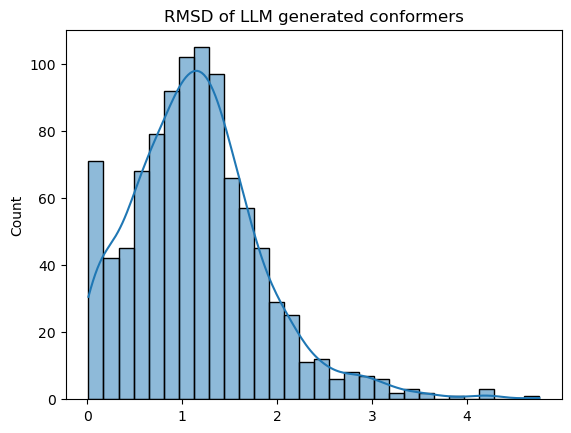

In [12]:
na_dropped_rmsds = [rmsd for rmsd in rmsds if rmsd]
print("Number of valid RMSD values:", len(na_dropped_rmsds))

BINS = 30

# Histogram of RMSD with KDE
plt.title("RMSD of LLM generated conformers")
sns.histplot(na_dropped_rmsds, bins=BINS, kde=True)
plt.show()


In [13]:
pd.DataFrame(na_dropped_rmsds).describe()

,0
count,985.000000
mean,1.158992
std,0.698444
min,0.013390
25%,0.677691
50%,1.106333
75%,1.528313
max,4.760334


## Beam Search

In [63]:
# In[XYZ]: Implement Sampling for More Diversity & Save Multiple RMSDs
import warnings
warnings.filterwarnings("ignore")

model.to("cuda:1")

# Configuration for more diverse generation.
# You can tune these for more or less variety:
num_beams = 3
num_return_sequences = 3
temperature = 1.0     # you can tune this up or down. 1.0 is fairly neutral
top_k = 50            # random sampling from top K tokens
top_p = 0.95          # nucleus (top-p) sampling
do_sample = True      # enable sampling
batch_size = 50
num_mols = len(gt_mols)

# You can keep the tokenizer pad token assignment as before
tokenizer.pad_token = tokenizer.eos_token

# We'll store RMSDs in a list of lists. 
# each row: RMSDs for one molecule
# each column: RMSD value for each returned sequence
all_rmsds_matrix = []
all_predicted_props = []  # If you also want property predictions from each beam

for batch_start in tqdm(range(0, num_mols, batch_size)):
    batch_gmols = gt_mols[batch_start : batch_start + batch_size]
    
    # Prepare prompts for the batch
    prompts = [
        f"[SMILES]{rdkit.Chem.MolToSmiles(gt_mol, canonical=True, isomericSmiles=False)}[/SMILES]"
        for gt_mol in batch_gmols
    ]
    
    # Tokenize the batch
    inputs = tokenizer(
        prompts, 
        return_tensors="pt", 
        add_special_tokens=True, 
        padding=True,
        padding_side="left"
    ).to(model.device).input_ids
    
    # Generate outputs using sampling + beam search
    # Early stopping ensures generation stops if the LLM hits an EOS token
    # or it's unlikely to produce more meaningful text.
    outputs = model.generate(
        inputs, 
        max_length=1000,
        num_beams=num_beams,
        num_return_sequences=num_return_sequences,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        do_sample=do_sample,
        early_stopping=True
    )

    # Now, outputs is of size [batch_size * num_return_sequences, seq_length].
    # We need to group them correctly back per molecule in the batch.
    decoded_batch = []
    for i in range(0, len(outputs), num_return_sequences):
        decoded_group = []
        for j in range(num_return_sequences):
            beam_output = outputs[i + j]
            # skip_special_tokens can cause partial prompt text to vanish,
            # so you may keep skip_special_tokens=False if your model relies on special tokens
            decoded_group.append(tokenizer.decode(beam_output, skip_special_tokens=False))
        decoded_batch.append(decoded_group)

    # decoded_batch is a list of length batch_size. 
    # Each element is a list of length num_return_sequences with the text for each beam.

    # Now parse each group of sequences and compute RMSDs
    for decoded_outputs_for_mol, gt_mol in zip(decoded_batch, batch_gmols):
        mol_rmsds = []
        mol_props = []
        for single_decoded_output in decoded_outputs_for_mol:
            # Predict property
            try:
                prop_str = single_decoded_output.split("PROPERTY")[1].split("</PROPERTY>")[0].strip()[1:-2]
                prop_val = float(prop_str)
                mol_props.append(prop_val)
            except (IndexError, ValueError):
                mol_props.append(None)

            # Predict conformer & RMSD
            try:
                conf_smi = single_decoded_output.split("CONFORMER")[1].split("</CONFORMER>")[0].strip()[1:-2]
                conf_mol = parse_embedded_smiles(conf_smi)
                # Calculate RMSD
                rmsd_val = calculate_rmsd(conf_mol, gt_mol)
                mol_rmsds.append(rmsd_val)
            except (IndexError, ValueError):
                mol_rmsds.append(None)

        # Store data for this ground truth molecule
        all_rmsds_matrix.append(mol_rmsds)
        all_predicted_props.append(mol_props)

# Convert lists to numpy arrays if you prefer
import numpy as np
all_rmsds_matrix = np.array(all_rmsds_matrix, dtype=object)  # shape: [num_mols, num_return_sequences]
all_predicted_props = np.array(all_predicted_props, dtype=object)

print("Shape of RMSDs matrix:", all_rmsds_matrix.shape)
print("Sample RMSDs row:", all_rmsds_matrix[0])

  0%|          | 0/20 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
  5%|▌         | 1/20 [00:35<11:08, 35.17s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
 10%|█         | 2/20 [01:11<10:44, 35.79s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
[13:58:40] Explicit valence for atom # 1 B, 5, is greater than permitted
[13:58:40] Explicit valence for atom # 1 

Shape of RMSDs matrix: (1000, 3)
Sample RMSDs row: [0.06368246143188416 0.06368246143188416 0.06368246143188416]


In [65]:
# Convert lists to numpy arrays if you prefer
import numpy as np
all_rmsds_matrix = np.array(all_rmsds_matrix)  # shape: [num_mols, num_return_sequences]
all_pred_props_matrix = np.array(all_predicted_props)

all_rmsds_matrix.shape

(1000, 3)

In [66]:
llama_rmsds_mean = []
llama_rmsds_min = []
nans = []
i = 0
for r in all_rmsds_matrix:
   try:
       llama_rmsds_mean.append(np.mean(r))
       llama_rmsds_min.append(np.min(r))
   except:
       nans.append(r)
       i += 1
       

print("Number of nan RMSDs:", i)
nans

Number of nan RMSDs: 848


[array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=object),
 array([None, None, None], dtype=o

In [67]:
print("Mean RMSD of LLM generated conformers:")
print(pd.DataFrame(llama_rmsds_mean).describe())
print("\n")
print("Min RMSD of LLM generated conformers:")
print(pd.DataFrame(llama_rmsds_min).describe())
print("\n")


Mean RMSD of LLM generated conformers:
                0
count  147.000000
mean     1.002338
std      0.717918
min      0.012559
25%      0.479733
50%      0.849775
75%      1.437607
max      3.123911


Min RMSD of LLM generated conformers:
                0
count  147.000000
mean     1.002284
std      0.717933
min      0.012550
25%      0.479722
50%      0.849762
75%      1.437603
max      3.123898




# RDKit conformers

In [14]:
import warnings
warnings.filterwarnings("ignore")
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*')
from rdkit.Chem import AllChem

N = 25
steps = 200
rdkit_rmsds = []

for smi, gt_mol in tqdm(zip(smiles, gt_mols)):
    mol = rdkit.Chem.MolFromSmiles(smi)
    if mol is None:
        print(f"Failed to parse {smi}")
        continue

    # Embed 
    conformer_ids = AllChem.EmbedMultipleConfs(
        mol,
        numConfs=N,
        maxAttempts=steps,
        randomSeed=42,
        pruneRmsThresh=0.5  # Prune conformers that are too similar
    )
    AllChem.UFFOptimizeMoleculeConfs(mol, maxIters=steps)
    rmsds = calculate_rmsd_matrix(gt_mol, mol)
    rdkit_rmsds.append(rmsds)



1000it [00:51, 19.41it/s]


In [15]:
np.sum([len(r) for r in rdkit_rmsds])

np.int64(15785)

In [16]:
rdkit_mean_rmsds = [np.mean(r) for r in rdkit_rmsds]
rdkit_min_rmsds = [np.min(r) for r in rdkit_rmsds]

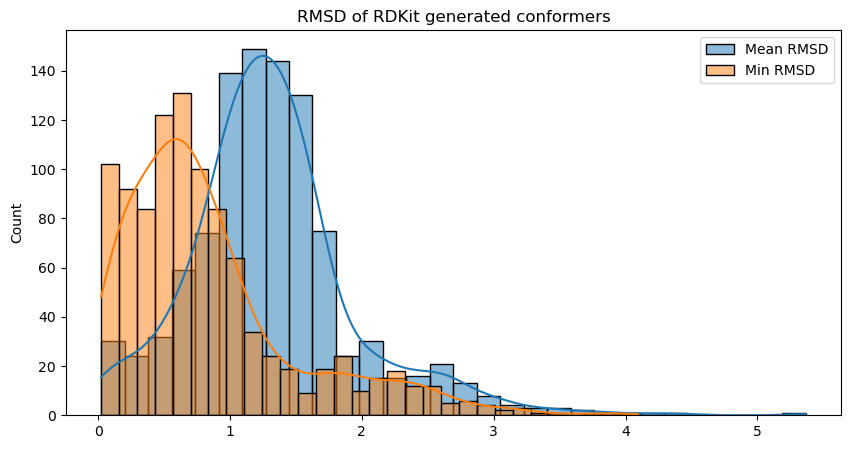

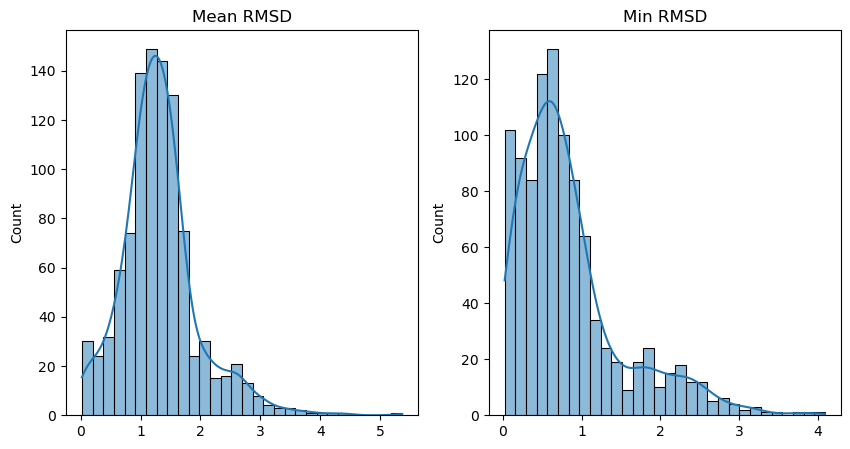

Min RMSD of RDKit generated conformers:
                 0
count  1000.000000
mean      0.838612
std       0.676357
min       0.021133
25%       0.373188
50%       0.667989
75%       1.023384
max       4.093617


Mean RMSD of RDKit generated conformers:
                 0
count  1000.000000
mean      1.318134
std       0.640451
min       0.021133
25%       0.952027
50%       1.263936
75%       1.563244
max       5.366920




In [31]:
# Histogram of RMSD with KDE, side by side for min and mean
plt.figure(figsize=(10, 5))
sns.histplot(rdkit_mean_rmsds, bins=BINS, kde=True, label="Mean RMSD")
sns.histplot(rdkit_min_rmsds, bins=BINS, kde=True, label="Min RMSD")
plt.title("RMSD of RDKit generated conformers")
plt.legend()
plt.show()

# Another figure to compare the two as separate histograms, as side by side plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(rdkit_mean_rmsds, bins=BINS, kde=True, label="Mean RMSD")
plt.title("Mean RMSD")
plt.subplot(1, 2, 2)
sns.histplot(rdkit_min_rmsds, bins=BINS, kde=True, label="Min RMSD")
plt.title("Min RMSD")
plt.show()

print("Min RMSD of RDKit generated conformers:")
print(pd.DataFrame(rdkit_min_rmsds).describe())
print("\n")
print("Mean RMSD of RDKit generated conformers:")
print(pd.DataFrame(rdkit_mean_rmsds).describe())
print("\n")


# Ginger logs

In [37]:
from rdkit.Chem import SDMolSupplier
mols = {}

GINGER_SDF = "/auto/home/davit/3DMolGen/valid_2d_ginger.sdf"
# GINGER_SDF = "/auto/home/davit/3DMolGen/valid_2d_ginger_censo.sdf"

for i, gt_mol in enumerate(gt_mols):
    mols[i] = {'gt_mol': gt_mol, 'ginger_mols': []}

invalid_mols = 0

for mol in SDMolSupplier(GINGER_SDF):
    if mol is None:
        invalid_mols += 1
        continue

    index = mol.GetProp("index")
    mols[int(index)]['ginger_mols'].append(mol)

print("Unskipped:", len([m for m in mols if len(mols[m]['ginger_mols']) > 0]))

[12:45:07] ERROR: Cannot convert ' -/2' to int on line 1560
[12:45:07] ERROR: moving to the beginning of the next molecule
[12:45:07] ERROR: Cannot convert ' -/2' to int on line 1667
[12:45:07] ERROR: moving to the beginning of the next molecule
[12:45:07] ERROR: Cannot convert ' -/2' to int on line 1774
[12:45:07] ERROR: moving to the beginning of the next molecule
[12:45:07] ERROR: Cannot convert ' -/2' to int on line 1881
[12:45:07] ERROR: moving to the beginning of the next molecule
[12:45:07] ERROR: Cannot convert ' -/2' to int on line 1988
[12:45:07] ERROR: moving to the beginning of the next molecule
[12:45:07] ERROR: Cannot convert ' -/2' to int on line 2095
[12:45:07] ERROR: moving to the beginning of the next molecule
[12:45:07] ERROR: Cannot convert ' -/2' to int on line 2202
[12:45:07] ERROR: moving to the beginning of the next molecule
[12:45:07] ERROR: Cannot convert ' -/2' to int on line 2309
[12:45:07] ERROR: moving to the beginning of the next molecule
[12:45:07] ERROR

Unskipped: 863


In [38]:
print("Number of invalid confs:", invalid_mols)
print("Average # of ginger confs per gt mol:", np.mean([len(mols[i]['ginger_mols']) for i in mols]))
print("Number of confs:", np.sum([len(mols[i]['ginger_mols']) for i in mols]))

Number of invalid confs: 2266
Average # of ginger confs per gt mol: 13.067
Number of confs: 13067


In [39]:
ginger_rmsds = []
ginger_posebusters = []

for i in tqdm(mols):
    gt_mol = mols[i]['gt_mol']
    ginger_mols = mols[i]['ginger_mols']
    row = []

    for ginger_mol in ginger_mols:
        rmsd = calculate_rmsd(ginger_mol, gt_mol)
        row.append(rmsd)
        ginger_posebusters.append(get_conformer_statistics(ginger_mol)['results'])

    ginger_rmsds.append(row)

ginger_posebusters = pd.concat(ginger_posebusters)

 50%|█████     | 500/1000 [05:30<04:10,  2.00it/s][12:50:57] UFFTYPER: Unrecognized charge state for atom: 1
[12:50:57] UFFTYPER: Unrecognized charge state for atom: 1
[12:50:57] UFFTYPER: Unrecognized charge state for atom: 1
[12:50:57] UFFTYPER: Unrecognized charge state for atom: 1
[12:50:57] UFFTYPER: Unrecognized charge state for atom: 1
 64%|██████▍   | 640/1000 [06:20<01:49,  3.28it/s][12:51:48] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[12:51:48] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[12:51:48] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[12:51:48] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[12:51:48] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[12:51:48] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[12:51:48] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[12:51:48] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[12:51:48] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[12:51:48] UFFTYPER: Unrecognized atom type: S_5+4 (1)
[12:51:48] UFFTYPER: Unrecognized atom type: S_5+4 (1)


In [40]:
boolean_cols = [col for col in ginger_posebusters.columns if ginger_posebusters[col].dtype == "bool"]

ginger_posebusters[boolean_cols].sum() / len(ginger_posebusters)

mol_pred_loaded           1.000000
sanitization              1.000000
inchi_convertible         0.999235
all_atoms_connected       1.000000
bond_lengths              1.000000
bond_angles               1.000000
internal_steric_clash     0.997857
aromatic_ring_flatness    1.000000
double_bond_flatness      1.000000
mol_true_loaded           0.000000
mol_cond_loaded           0.000000
passes_valence_checks     1.000000
passes_kekulization       1.000000
dtype: float64

In [41]:
mean_ginger_rmsds = [np.mean(r) for r in ginger_rmsds if r]
min_ginger_rmsds = [np.min(r) for r in ginger_rmsds if r]


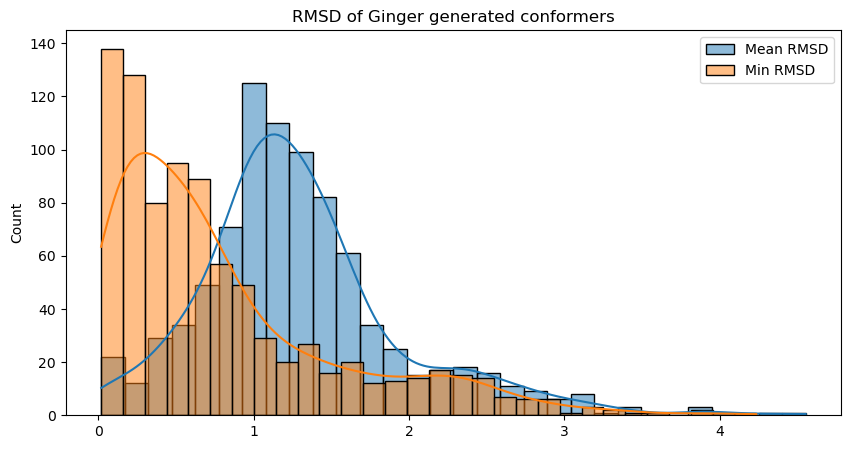

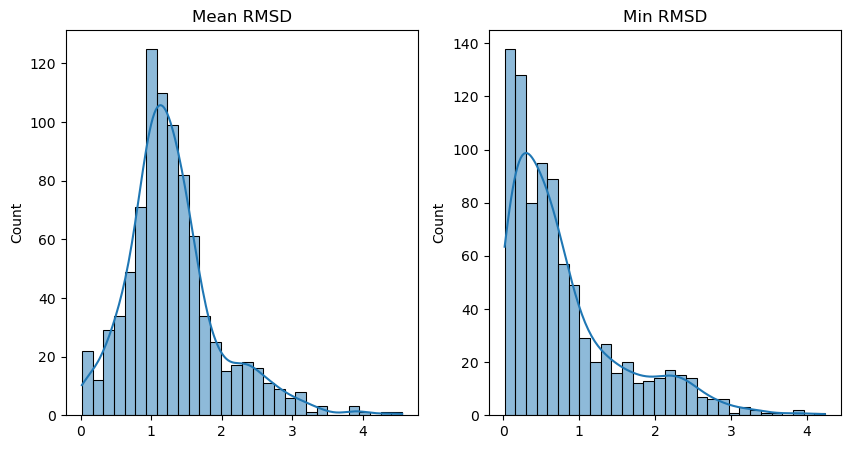

In [42]:
# Histogram of RMSD with KDE
# Histogram of RMSD with KDE, side by side for min and mean
plt.figure(figsize=(10, 5))
sns.histplot(mean_ginger_rmsds, bins=BINS, kde=True, label="Mean RMSD")
sns.histplot(min_ginger_rmsds, bins=BINS, kde=True, label="Min RMSD")
plt.title("RMSD of Ginger generated conformers")
plt.legend()
plt.show()

# Another figure to compare the two as separate histograms, as side by side plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(mean_ginger_rmsds, bins=BINS, kde=True, label="Mean RMSD")
plt.title("Mean RMSD")
plt.subplot(1, 2, 2)
sns.histplot(min_ginger_rmsds, bins=BINS, kde=True, label="Min RMSD")
plt.title("Min RMSD")
plt.show()


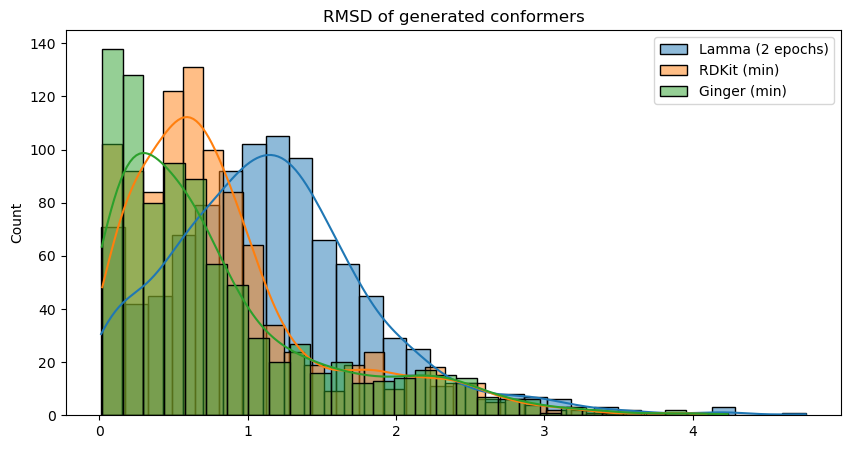

RMSD of LLM generated conformers:
                0
count  985.000000
mean     1.158992
std      0.698444
min      0.013390
25%      0.677691
50%      1.106333
75%      1.528313
max      4.760334


RMSD of RDKit generated conformers:
                 0
count  1000.000000
mean      0.838612
std       0.676357
min       0.021133
25%       0.373188
50%       0.667989
75%       1.023384
max       4.093617


Mean RMSD of Ginger generated conformers:
                0
count  863.000000
mean     1.298476
std      0.658023
min      0.018810
25%      0.922159
50%      1.201946
75%      1.547483
max      4.552724


Min RMSD of Ginger generated conformers:
                0
count  863.000000
mean     0.798184
std      0.751167
min      0.017715
25%      0.243527
50%      0.555616
75%      1.060468
max      4.234225


In [70]:
# Print the combined histogram of min_rdkit_rmsds and min_ginger_rmsds and na_dropped_rmsds
plt.figure(figsize=(10, 5))
sns.histplot(na_dropped_rmsds, bins=BINS, kde=True, label="Lamma (2 epochs)")
sns.histplot(rdkit_min_rmsds, bins=BINS, kde=True, label="RDKit (min)")
sns.histplot(min_ginger_rmsds, bins=BINS, kde=True, label="Ginger (min)")
plt.legend()
plt.title("RMSD of generated conformers")
plt.show()

# describe the rmsds
print("RMSD of LLM generated conformers:")
print(pd.DataFrame(na_dropped_rmsds).describe())
print("\n")
print("RMSD of RDKit generated conformers:")
print(pd.DataFrame(rdkit_min_rmsds).describe())
print("\n")
print("Mean RMSD of Ginger generated conformers:")
print(pd.DataFrame(mean_ginger_rmsds).describe())
print("\n")
print("Min RMSD of Ginger generated conformers:")
print(pd.DataFrame(min_ginger_rmsds).describe())